In [44]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [45]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [46]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [47]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [48]:
# reflect an existing database into a new model

# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [49]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset
measurement_station_count = session.query(Measurement.station).distinct().count()
station_count = session.query(Station).count()

print(f"There are a count of {station_count} stations in the Station table and {measurement_station_count} distinct stations referenced in the Measurement table.")

There are a count of 9 stations in the Station table and 9 distinct stations referenced in the Measurement table.


In [21]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

station_counts_df = pd.DataFrame(station_counts, columns=['Station', 'Station Activity Count'])
station_counts_df

,Station,Station Activity Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [38]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).limit(1)[0][0]

station_temp = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station==station).all()

station_temp_df = pd.DataFrame(station_temp, columns=['Station', 'TOBS'])
station_temp_df['TOBS'].fillna(0, inplace=True)
station_temp_df['TOBS'].aggregate(['min', 'max', 'mean'])


min     54.000000
max     85.000000
mean    71.663781
Name: TOBS, dtype: float64

In [42]:
# alternate way using sql alchemey as per readme

station_temp_alt = session.query(Measurement.station, \
    func.min(Measurement.tobs).label("min"),\
    func.max(Measurement.tobs).label("max"),\
    func.avg(Measurement.tobs).label("avg")).\
    filter(Measurement.station==station).all()

station_temp_alt_df = pd.DataFrame(station_temp_alt, columns=['station', 'min', 'max', 'avg'])
station_temp_alt_df

,station,min,max,avg
0,USC00519281,54.0,85.0,71.663781


Text(0, 0.5, 'Frequency')

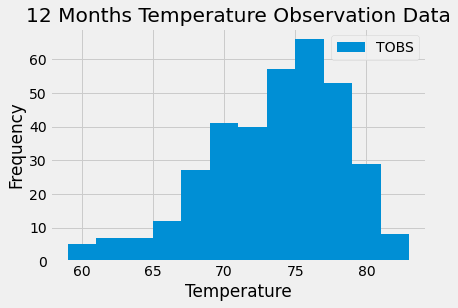

In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
import datetime as dt
from dateutil import parser
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()[0][0]
most_recent_date = parser.parse(most_recent_date)

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the date and temperature data
station_tobs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station==station).\
    filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d'), Measurement.date <= most_recent_date.strftime('%Y-%m-%d')).\
    all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(station_tobs, columns=['Date', 'TOBS'])
df['TOBS'].fillna(0, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")
df.set_index('Date', inplace=True)

# Sort the dataframe by date
df.sort_index()

df.plot(kind='hist', bins=12, grid=True, title='12 Months Temperature Observation Data')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Close session

In [43]:
# Close Session
session.close()